In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import random

In [2]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

## Load Data

### Source Data

In [3]:
from datasets.huavei import HuaveiLoader

base_dir = "/home/gosha20777/Zurich-RAW-to-DSLR-Dataset"
train_input_dir = os.path.join(base_dir, "train/huawei_raw")
train_target_dir = os.path.join(base_dir, "train/canon")
test_input_dir = os.path.join(base_dir, "test/huawei_raw")
test_target_dir = os.path.join(base_dir, "test/canon")
img_size = (224, 224)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".jpg")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(test_target_dir, fname)
        for fname in os.listdir(test_target_dir)
        if fname.endswith(".jpg")
    ]
)

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    
val_samples = 4000
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
source_train_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
source_val_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(source_train_gen))
print("Number val batches:", len(source_val_gen))

0.png | 0.jpg
1.png | 1.jpg
10.png | 10.jpg
100.png | 100.jpg
1000.png | 1000.jpg
10000.png | 10000.jpg
10001.png | 10001.jpg
10002.png | 10002.jpg
10003.png | 10003.jpg
10004.png | 10004.jpg
Number of samples: 46839
Number train batches: 5354
Number val batches: 500


### Target Data

In [4]:
from datasets.mai import MaiLoader

base_dir = "/home/gosha20777/MAI2021"
train_input_dir = os.path.join(base_dir, "mediatek_raw")
train_target_dir = os.path.join(base_dir, "fujifilm")
img_size = (128, 128)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    

val_samples = 20000
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
target_train_gen = MaiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
target_val_gen = MaiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(target_train_gen))
print("Number val batches:", len(target_val_gen))

0.png | 0.png
1.png | 1.png
10.png | 10.png
100.png | 100.png
1000.png | 1000.png
10000.png | 10000.png
10001.png | 10001.png
10002.png | 10002.png
10003.png | 10003.png
10004.png | 10004.png
Number of samples: 24161
Number train batches: 520
Number val batches: 2500


### Dann Data

In [5]:
from datasets.dann import DannLoader

dann_train_gen = DannLoader(
    source_loader=source_train_gen,
    target_loader=target_train_gen
)

dann_val_gen = DannLoader(
    source_loader=source_val_gen,
    target_loader=target_val_gen
)

print("Number train batches:", len(dann_train_gen))
print("Number val batches:", len(dann_val_gen))

Number train batches: 520
Number val batches: 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


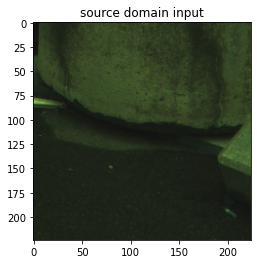

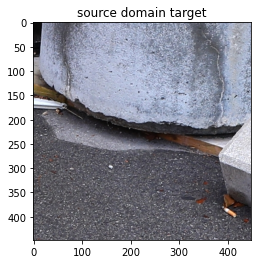

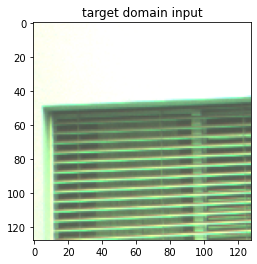

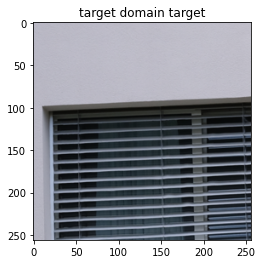

In [6]:
x, y = dann_val_gen.__getitem__(0)
s_x, t_x = x 
s_y, t_y, d_s_y, d_t_y = y

plt_display(s_x[3][:,:,0:3], 'source domain input')
plt_display(s_y[3], 'source domain target')

plt_display(t_x[3][:,:,0:3], 'target domain input')
plt_display(t_y[3], 'target domain target')

## Evaluate Source Domain Trained Netwark on Target Domain

In [5]:
from losses.losses import mssim, vgg_loss

def main_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred) + \
        mssim(y_true, y_pred) + \
        vgg_loss(y_true, y_pred)

def source_loss(y_true, y_pred):
    return mssim(y_true, y_pred) + \
        vgg_loss(y_true, y_pred)

def target_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

In [14]:
from models import encoder, unet, domain_classifyer, dann

s_encoder = encoder.get_model()
s_encoder.load_weights('s_encoder_zurich.h5')
u_net = unet.get_model()
u_net.load_weights('s_u_net_zurich.h5')

s_model = dann.SingleNet(
    encoder=s_encoder,
    u_net=u_net
)

s_model.compile(optimizer="adam", loss_fn=main_loss, metrics=[psnr, ssim])

In [15]:
print("Evaluate on test data")
psnr_val, ssim_val, _ = s_model.evaluate(target_val_gen)
print(f"psnr: {psnr_val}, ssim: {ssim_val}")

Evaluate on test data
2500/2500 [==============================] - 156s 58ms/step - psnr: 5.8686 - ssim: 0.4736 - source_loss: 2.4200
psnr: 5.876317977905273, ssim: 0.47391968965530396


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


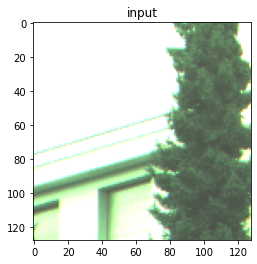

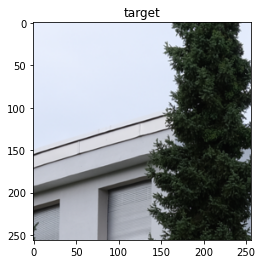

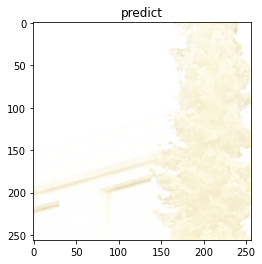

In [16]:
x, y = target_val_gen.__getitem__(0)
preds = s_model.predict(x)
plt_display(x[0][:,:,0:3], 'input')
plt_display(y[0], 'target')
plt_display(preds[0], 'predict')

## Domain Adaptation Network

In [8]:
from models import encoder, unet, domain_classifyer, dann

s_encoder = encoder.get_model()
s_encoder.load_weights('s_encoder_zurich.h5')
t_encoder = encoder.get_model()
t_encoder.load_weights('s_encoder_zurich.h5')
u_net = unet.get_model()
u_net.load_weights('s_u_net_zurich.h5')
d_decoder = domain_classifyer.get_model()

dann_model = dann.DannNet(
    source_encoder=s_encoder,
    target_encoder=t_encoder,
    u_net=u_net,
    domain_classifyer=d_decoder
)

### Train

In [9]:
dann_model.compile(optimizer="adam", metrics=[psnr, ssim], s_loss=source_loss, t_loss=target_loss)

epochs = 4

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/dann_zurich2mai")
]

history = dann_model.fit(dann_train_gen, epochs=epochs, validation_data=dann_val_gen, callbacks=callbacks, workers=8)

Epoch 1/4
Tensor("IteratorGetNext:4", shape=(None, None), dtype=float32)
Tensor("model_6/model_4/dense_1/Sigmoid:0", shape=(None, 1), dtype=float32)
Tensor("IteratorGetNext:4", shape=(None, None), dtype=float32)
Tensor("model_6/model_4/dense_1/Sigmoid:0", shape=(None, 1), dtype=float32)
520/520 [==============================] - 331s 536ms/step - psnr: 19.6724 - ssim: 0.7426 - source_loss: 0.8527 - target_loss: 0.0824 - domain_classifyer_loss: 0.6967 - val_psnr: 22.4193 - val_ssim: 0.7235 - val_target_loss: 0.0497
Epoch 2/4
520/520 [==============================] - 280s 539ms/step - psnr: 21.8226 - ssim: 0.8040 - source_loss: 0.8293 - target_loss: 0.0718 - domain_classifyer_loss: 0.6933 - val_psnr: 23.0974 - val_ssim: 0.7450 - val_target_loss: 0.0316
Epoch 3/4
520/520 [==============================] - 280s 538ms/step - psnr: 22.1189 - ssim: 0.8124 - source_loss: 0.8193 - target_loss: 0.0711 - domain_classifyer_loss: 0.6936 - val_psnr: 22.9811 - val_ssim: 0.7440 - val_target_loss: 0.0

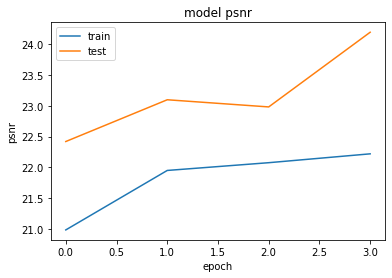

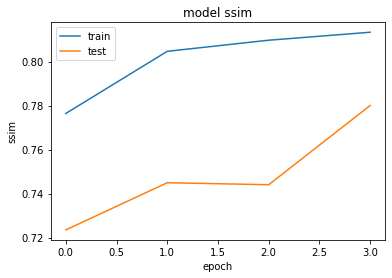

In [10]:
# summarize history for psnr
plt.plot(history.history['psnr'])
plt.plot(history.history['val_psnr'])
plt.title('model psnr')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for ssim
plt.plot(history.history['ssim'])
plt.plot(history.history['val_ssim'])
plt.title('model ssim')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save

In [11]:
t_encoder.save('dann_zurich2mai_encoder.h5')
u_net.save('dann_zurich2mai_u_net.h5')

### Evaluate

In [6]:
from models import encoder, unet, domain_classifyer, dann

t_encoder = encoder.get_model()
t_encoder.load_weights('dann_zurich2mai_encoder.h5')
u_net = unet.get_model()
u_net.load_weights('dann_zurich2mai_u_net.h5')

t_model = dann.SingleNet(
    encoder=t_encoder,
    u_net=u_net
)

In [7]:
t_model.compile(optimizer="adam", metrics=[psnr, ssim], loss_fn=main_loss)

print("Evaluate on test data")
psnr_val, ssim_val, _ = t_model.evaluate(target_val_gen)
print(f"psnr: {psnr_val}, ssim: {ssim_val}")

Evaluate on test data
2500/2500 [==============================] - 157s 58ms/step - psnr: 23.1509 - ssim: 0.8597 - source_loss: 0.4911
psnr: 23.145286560058594, ssim: 0.8600098490715027


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


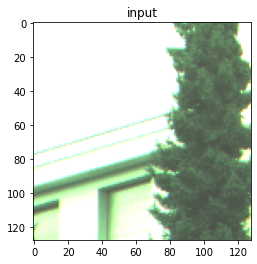

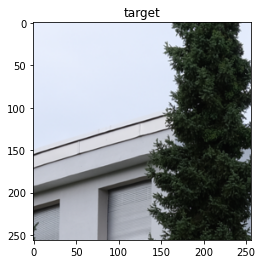

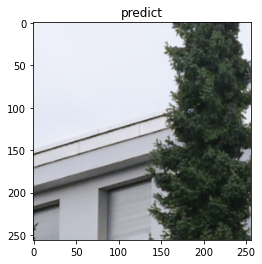

In [8]:
x, y = target_val_gen.__getitem__(0)
preds = t_model.predict(x)
plt_display(x[0][:,:,0:3], 'input')
plt_display(y[0], 'target')
plt_display(preds[0], 'predict')